In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import swifter
pd.set_option('display.max_columns', None)

In [73]:
recipes = pd.read_csv('./recipes.csv')
requests = pd.read_csv('./requests.csv')
reviews = pd.read_csv('./reviews.csv')
diet = pd.read_csv('./diet.csv')
classify_diet = pd.read_csv('./classify_diet.csv', sep=':;')

/tmp/ipykernel_6517/1304735388.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv('./reviews.csv')
/tmp/ipykernel_6517/1304735388.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  classify_diet = pd.read_csv('./classify_diet.csv', sep=':;')


In [74]:
recipes['RecipeIngredientParts'] = recipes['RecipeIngredientParts'].apply(lambda x: x.replace('\\','').replace('"','').replace('c(', '').replace(')','').replace('(',''))
recipes['RecipeIngredientQuantities'] = recipes['RecipeIngredientQuantities'].apply(lambda x: x.replace('\\','').replace('"','').replace('c(', '').replace(')','').replace('(',''))

def func(x):
    res = []
    for y in x.split(','):
        y = y.strip().lower().replace('-',' ')
        found = classify_diet.loc[classify_diet['Ingredient'] == y]['Diet'].values
        if len(found) == 0:
            print(y)
            continue
        else:
            res.append(found[0])
    return res

# add meal type
classify_diet['Ingredient'] = classify_diet['Ingredient'].str.lower().str.strip().str.replace('(', '').str.replace(')', '').replace('-',' ')
recipes['RecipeIngredientParts'] = recipes['RecipeIngredientParts'].str.lower().str.strip().replace('-',' ')

#classify_diet
print(len(recipes))
recipes['DietIngredient'] = recipes['RecipeIngredientParts'].swifter.allow_dask_on_strings(enable=True).apply(func)

recipes['DietIngredient']

75604


Dask Apply:   0%|          | 0/32 [00:00<?, ?it/s]

0        [Vegan, Vegan, Vegan, Vegan, Vegan, Vegan, Veg...
1        [Vegetarian, Vegetarian, Vegetarian, Vegetaria...
2        [Omnivore, Vegetarian, Vegetarian, Vegan, Vege...
3        [Vegetarian, Vegetarian, Vegetarian, Vegetaria...
4        [Vegan, Vegan, Vegetarian, Vegan, Vegan, Vegan...
                               ...                        
75599    [Vegetarian, Vegan, Vegan, Vegetarian, Vegan, ...
75600    [Vegetarian, Vegan, Vegan, Vegetarian, Vegan, ...
75601    [Omnivore, Vegetarian, Vegetarian, Vegetarian,...
75602                                       [Vegan, Vegan]
75603    [Vegan, Vegan, Vegan, Vegetarian, Vegan, Veget...
Name: DietIngredient, Length: 75604, dtype: object

In [75]:
def decideDiet(x):
    if list(set(x)) == list(['Vegan']):
        return 'Vegan'
    if list(set(x)) == list(['Vegetarian']) or list(set(x)) == list(['Vegan', 'Vegetarian']):
        return 'Vegetarian'
    return 'Omnivore'


recipes['DietRecipe'] = recipes['DietIngredient'].apply(decideDiet)
recipes['DietRecipe']

0        Vegetarian
1          Omnivore
2          Omnivore
3          Omnivore
4        Vegetarian
            ...    
75599      Omnivore
75600      Omnivore
75601      Omnivore
75602         Vegan
75603    Vegetarian
Name: DietRecipe, Length: 75604, dtype: object

In [76]:
# join recipes and requests
joined = recipes.merge(reviews, on='RecipeId', how='inner')

# join with diet
joined = joined.merge(diet, on='AuthorId', how='inner')

# join with requests
all = joined.merge(requests, on=['RecipeId', 'AuthorId'], how='inner')

In [77]:
mapping = {
    'RecipeCategory': 'string',
    'RecipeIngredientQuantities': 'string',
    'RecipeIngredientParts': 'string',
    'Name': 'string',
    'AuthorId': 'string',
    'Like': 'bool',
    'Diet': 'string',
    'HighCalories': 'bool',
    'HighProtein': 'string',
    'LowFat': 'bool',
    'LowSugar': 'string',
    'HighFiber': 'bool'
}
df = all.astype(mapping)

In [78]:
# add feature Rated
df['Rated'] = df['Rating'].apply(lambda x: True if x > 0 else False)

# HighProtein and LowSugar have only two values
mapping = {
    'HighProtein': 'bool',
    'LowSugar': 'bool',
}
df = df.astype(mapping)

# add feature MatchesDiet and DietCompatible
def dietComatible(row):
    diet = row['Diet']
    diet_recipe = row['DietRecipe']
    if diet == 'Vegan':
        return diet_recipe == 'Vegan'
    if diet == 'Vegetarian':
        return (diet_recipe == 'Vegan' or diet_recipe == 'Vegetarian')
    return True
df['MatchesDiet'] = df['Diet'] == df['DietRecipe']
df['DietCompatible'] = df.apply(dietComatible, axis=1)

In [79]:
print(df.groupby("Like").size())

Like
False    84503
True     55692
dtype: int64


In [80]:
def boxplot(column):
    sns.boxplot(data=df,x=df[f"{column}"])
    plt.show()

cols = ['Age', 'CookTime', 'PrepTime', 'Calories', 'FatContent', 'SaturatedFatContent', 'CarbohydrateContent', 'FiberContent', 
        'SugarContent', 'ProteinContent', 'SodiumContent', 'CholesterolContent']

#for col in cols:
    #boxplot(col)

In [81]:
mapping = {
    'Diet': 'category',
    'DietRecipe': 'category',
    'RecipeCategory': 'category'
}
df = df.astype(mapping)
df = pd.get_dummies(df, columns=['Diet', 'DietRecipe', 'RecipeCategory'])

In [82]:
""" df['TimePerServing'] = df['CookTime'] / df['RecipeServings']
df['TotalTime'] = df['CookTime'] + df['PrepTime']
df['TotalTimePerServing'] = df['RecipeServings'] / df['TotalTime']
df['CaloriesPerServing'] = df['Calories'] / df['RecipeServings'] """

bins = [0, 18, 24, 34, 44, 54, 64, 100]
labels = ['0-18', '19-24', '25-34', '35-44', '45-54', '55-64', '65+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)
df = pd.get_dummies(df, columns=['AgeGroup'])

df['TimePerServing']


0           0.0
1         120.0
2           0.0
3          75.0
4           0.0
          ...  
140190    150.0
140191      NaN
140192      NaN
140193    900.0
140194      NaN
Name: TimePerServing, Length: 140195, dtype: float64

Until here all feature engineering stuff must be done

We can see some outlier which we will remove

In [83]:
# takes around 3 minutes
print(list(df))
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

numeric_cols = ['Age', 'CookTime', 'PrepTime', 'Calories', 'FatContent', 'SaturatedFatContent', 'CarbohydrateContent', 'FiberContent', 
        'SugarContent', 'ProteinContent', 'SodiumContent', 'CholesterolContent']
df_lof = df[numeric_cols]

scaler = MinMaxScaler()
df_lof = scaler.fit_transform(df_lof)

clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(df_lof)
X_scores = clf.negative_outlier_factor_

df['Outlier'] = X_scores

['RecipeId', 'Name', 'CookTime', 'PrepTime', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'RecipeYield', 'DietIngredient', 'AuthorId', 'Rating', 'Like', 'TestSetId', 'Age', 'Time', 'HighCalories', 'HighProtein', 'LowFat', 'LowSugar', 'HighFiber', 'Rated', 'MatchesDiet', 'DietCompatible', 'Diet_Omnivore', 'Diet_Vegan', 'Diet_Vegetarian', 'DietRecipe_Omnivore', 'DietRecipe_Vegan', 'DietRecipe_Vegetarian', 'RecipeCategory_Beverages', 'RecipeCategory_Bread', 'RecipeCategory_Breakfast', 'RecipeCategory_Lunch', 'RecipeCategory_One dish meal', 'RecipeCategory_Other', 'RecipeCategory_Soup', 'TimePerServing', 'TotalTime', 'TotalTimePerServing', 'CaloriesPerServing', 'AgeGroup_0-18', 'AgeGroup_19-24', 'AgeGroup_25-34', 'AgeGroup_35-44', 'AgeGroup_45-54', 'AgeGroup_55-64', 'AgeGroup_65+']


In [84]:
train_all = df[df['TestSetId'].isna()]
test = df[df['TestSetId'].notna()]
print(len(train_all))
print(len(test))

97381
42814


In [85]:
threshold = -2
outlier = train_all[train_all['Outlier'] < threshold]
print(len(outlier))
outlier.head()

1896


,RecipeId,Name,CookTime,PrepTime,RecipeIngredientQuantities,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,DietIngredient,AuthorId,Rating,Like,TestSetId,Age,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber,Rated,MatchesDiet,DietCompatible,Diet_Omnivore,Diet_Vegan,Diet_Vegetarian,DietRecipe_Omnivore,DietRecipe_Vegan,DietRecipe_Vegetarian,RecipeCategory_Beverages,RecipeCategory_Bread,RecipeCategory_Breakfast,RecipeCategory_Lunch,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup,TimePerServing,TotalTime,TotalTimePerServing,CaloriesPerServing,AgeGroup_0-18,AgeGroup_19-24,AgeGroup_25-34,AgeGroup_35-44,AgeGroup_45-54,AgeGroup_55-64,AgeGroup_65+,Outlier
177,160180,Apricot Honey Syrup,2073600,600,"1/2, 3, 3, 4, 2","honey, sugar, water",6736.0,1.2,0.0,0.0,72.9,1780.3,18.6,1756.0,10.8,NaN,1 quart,"[Vegan, Vegetarian, Vegan]",1073154D,2.0,False,NaN,59,2.074200e+06,False,True,False,True,False,True,True,True,0,0,1,0,0,1,0,0,0,0,0,1,0,NaN,2074200,NaN,NaN,0,0,0,0,0,1,0,-2.704787
264,131949,Rack of Pork With Ginger Cooked in a Salt Crust,95400,900,"3 1/2, 6, 1, 3, 6, 13 1/2","garlic cloves, fresh parsley, olive oil, coars...",307.4,21.2,5.9,75.0,254719.4,5.0,0.9,0.5,23.5,6.0,NaN,"[Vegan, Vegetarian, Vegan, Vegan]",1622222C,NaN,False,NaN,32,9.629955e+04,True,True,True,True,True,False,True,True,0,0,1,0,0,1,0,0,0,0,0,1,0,15900.0,96300,0.000062,51.233333,0,0,1,0,0,0,0,-2.186308
324,128746,Chokecherry Vinegar - Chokecherry Shrub,600,86400,"3, 1, 1","vinegar, water, sugar",42.8,0.0,0.0,0.0,11.9,0.1,0.0,0.1,0.0,NaN,1 batch,"[Vegan, Vegan, Vegetarian]",163672D,2.0,False,NaN,38,8.700030e+04,False,True,False,True,True,True,True,True,0,0,1,0,0,1,0,0,0,0,0,1,0,NaN,87000,NaN,NaN,0,0,0,1,0,0,0,-7.626049
336,170485,Lipton Onion Sticks,0,0,"1, 1/2, 12",butter,2543.8,196.0,118.9,490.0,6482.6,175.5,9.8,20.7,27.8,1.0,NaN,[Vegetarian],163672D,2.0,False,NaN,38,-1.993706e+00,False,True,True,True,False,True,True,True,0,0,1,0,0,1,0,0,0,0,0,1,0,0.0,0,inf,2543.800000,0,0,0,1,0,0,0,-2.250910
427,100186,Mushroom Filling for Crepes,600,600,"20, 1/2, 500, 2, 3, 2","butter, onion, mushrooms, salt, heavy cream, p...",2717.3,281.6,174.9,1020.9,5058.1,39.7,4.7,10.0,26.4,NaN,1 batch of mushroom filling,"[Vegetarian, Vegetarian, Vegetarian, Vegan, Ve...",1802998197E,NaN,True,NaN,50,1.199572e+03,False,True,False,True,True,False,False,False,0,0,1,1,0,0,0,0,0,0,0,1,0,NaN,1200,NaN,NaN,0,0,0,0,1,0,0,-2.969269


In [86]:
train_all = train_all[train_all['Outlier'] >= threshold]
print(len(train_all))
train_all.head()

95485


,RecipeId,Name,CookTime,PrepTime,RecipeIngredientQuantities,RecipeIngredientParts,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,DietIngredient,AuthorId,Rating,Like,TestSetId,Age,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber,Rated,MatchesDiet,DietCompatible,Diet_Omnivore,Diet_Vegan,Diet_Vegetarian,DietRecipe_Omnivore,DietRecipe_Vegan,DietRecipe_Vegetarian,RecipeCategory_Beverages,RecipeCategory_Bread,RecipeCategory_Breakfast,RecipeCategory_Lunch,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup,TimePerServing,TotalTime,TotalTimePerServing,CaloriesPerServing,AgeGroup_0-18,AgeGroup_19-24,AgeGroup_25-34,AgeGroup_35-44,AgeGroup_45-54,AgeGroup_55-64,AgeGroup_65+,Outlier
163,73440,Bow Ties With Broccoli Pesto,0,1800,"6, 2, 1 1/2, 1/4, 1/2, 4, 1 1/2, 1 1/2, 5, 12","hazelnuts, broccoli florets, fresh parsley lea...",241.3,10.1,1.2,0.0,13.1,31.8,2.3,1.4,6.7,9.0,NaN,"[Vegan, Vegan, Vegan, Vegan, Vegan, Vegan, Veg...",1073154D,2.0,False,NaN,59,1799.844169,False,True,True,True,True,True,True,True,0,0,1,0,0,1,0,0,0,0,0,1,0,0.0,1800,0.005000,26.811111,0,0,0,0,0,1,0,-1.017536
164,214973,Carne Guisada (Stewed Beef),3000,1200,"2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1","beef round steak, onion, green pepper, garlic ...",331.6,18.9,6.2,92.3,235.8,5.7,1.4,2.6,33.4,NaN,NaN,"[Omnivore, Vegetarian, Vegetarian, Vegan, Vege...",1073154D,2.0,False,NaN,59,4200.065436,True,True,False,True,False,True,False,False,0,0,1,1,0,0,0,0,0,0,0,1,0,NaN,4200,NaN,NaN,0,0,0,0,0,1,0,-1.104046
165,87925,Veggie Puff Pastries,2400,1500,"1, 1, 1/2, 3 1/2, 2, 1, 1, 2, 1, 1, 1","puff pastry, egg, sweet potato, asparagus spea...",775.0,50.4,15.0,68.1,405.1,69.8,5.0,6.1,12.1,4.0,NaN,"[Vegetarian, Omnivore, Vegan, Vegan, Vegetaria...",1073154D,2.0,False,NaN,59,3900.449168,True,True,True,True,True,True,False,False,0,0,1,1,0,0,0,0,0,0,0,1,0,600.0,3900,0.001026,193.750000,0,0,0,0,0,1,0,-1.103623
166,111514,Delicious Fluffy Pancakes,1500,300,"1 1/2, 1 1/2, 1, 1 1/4, 3, 1, 2","flour, baking powder, salt, milk, butter, egg,...",170.6,6.6,3.8,43.2,553.5,23.5,0.6,3.3,4.5,NaN,8 pancakes,"[Vegetarian, Vegetarian, Vegan, Vegetarian, Ve...",1073154D,2.0,False,NaN,59,1800.542375,True,True,False,True,False,True,False,False,0,0,1,1,0,0,0,0,1,0,0,0,0,NaN,1800,NaN,NaN,0,0,0,0,0,1,0,-1.035581
167,8782,Garden Chicken,2100,1500,"4, 1, 5, 1, 1, 1, 4, 1, 1/2, 1/2, 2, 1, 1, 1, 1/3","boneless skinless chicken breast halves, garli...",436.2,19.1,10.6,95.6,501.4,37.3,2.2,3.2,27.8,6.0,1 casserole,"[Omnivore, Vegetarian, Vegetarian, Vegetarian,...",1073154D,NaN,False,NaN,59,3601.194876,True,True,False,True,True,False,False,False,0,0,1,1,0,0,0,0,0,0,0,1,0,350.0,3600,0.001667,72.700000,0,0,0,0,0,1,0,-0.980216


In [87]:
print(train_all.groupby("Like").size())

Like
False    82885
True     12600
dtype: int64


The class labels are uneven distributed. Therefore, we sample only a part of the False Like labels

In [88]:
false_sample = train_all[train_all['Like'] == False].sample(frac=0.5, random_state=1)
true_sample = train_all[train_all['Like'] == True]
true_sample = pd.concat([true_sample, true_sample, true_sample])

train_all = pd.concat([false_sample, true_sample])
print(len(train_all))
print(train_all.groupby("Like").size())

79242
Like
False    41442
True     37800
dtype: int64


In [95]:
from sklearn.model_selection import train_test_split

""" 
 'Diet_Omnivore',
 'Diet_Vegan',
 'Diet_Vegetarian',
 'DietRecipe_Omnivore',
 'DietRecipe_Vegan',
 'DietRecipe_Vegetarian',
 'RecipeCategory_Beverages',
 'RecipeCategory_Bread',
 'RecipeCategory_Breakfast',
 'RecipeCategory_Lunch',
 'RecipeCategory_One dish meal',
 'RecipeCategory_Other',
 'RecipeCategory_Soup',
"""

X_cols = [
 'CookTime',
 'PrepTime',
 'Calories',
 'FatContent',
 'SaturatedFatContent',
 'CholesterolContent',
 'SodiumContent',
 'CarbohydrateContent',
 'FiberContent',
 'SugarContent',
 'ProteinContent',
 #'Age',
 'Time',
 'HighCalories',
 'HighProtein',
 'LowFat',
 'LowSugar',
 'HighFiber',
 'Rated',
 'MatchesDiet',
 'DietCompatible',
 'AgeGroup_0-18', 
 'AgeGroup_19-24', 
 'AgeGroup_25-34', 
 'AgeGroup_35-44', 
 'AgeGroup_45-54', 
 'AgeGroup_55-64', 
 'AgeGroup_65+']
X = train_all[X_cols]
y = train_all['Like']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

In [102]:
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)


print(classification_report(y_val, y_pred))
print(balanced_accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.95      0.81      0.87     13676
        True       0.82      0.95      0.88     12474

    accuracy                           0.88     26150
   macro avg       0.88      0.88      0.88     26150
weighted avg       0.89      0.88      0.88     26150

0.8800220691855674


In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)


print(classification_report(y_val, y_pred))
print(balanced_accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.72      0.77      0.74     13676
        True       0.73      0.67      0.70     12474

    accuracy                           0.72     26150
   macro avg       0.72      0.72      0.72     26150
weighted avg       0.72      0.72      0.72     26150

0.7206906715778706


In [103]:
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score


#Creating an XGBoost classifier
model = xgb.XGBClassifier()

#Training the model on the training data
model.fit(X_train, y_train)

#Making predictions on the test set
predictions = model.predict(X_val)

print(classification_report(y_val, predictions))
print(balanced_accuracy_score(y_val, predictions))

              precision    recall  f1-score   support

       False       0.85      0.80      0.82     13676
        True       0.79      0.84      0.82     12474

    accuracy                           0.82     26150
   macro avg       0.82      0.82      0.82     26150
weighted avg       0.82      0.82      0.82     26150

0.8214460925170685


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

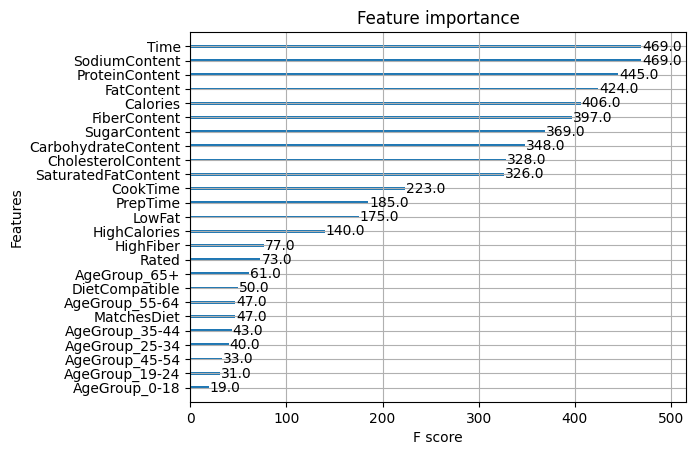

In [104]:
xgb.plot_importance(model)